<a href="https://colab.research.google.com/github/aydin-hasanli/recommender-big-four/blob/OPA/Movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
%matplotlib inline

In [ ]:
pip install lenskit

In [ ]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

In [ ]:
ml100k = ML100K('/content/ml-25m')


In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
mpl.rcParams['figure.figsize']=[10,8]
mpl.rcParams['axes.grid']=False

In [ ]:
movies=pd.read_csv('/content/ml-latest-small/movies.csv')

In [ ]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


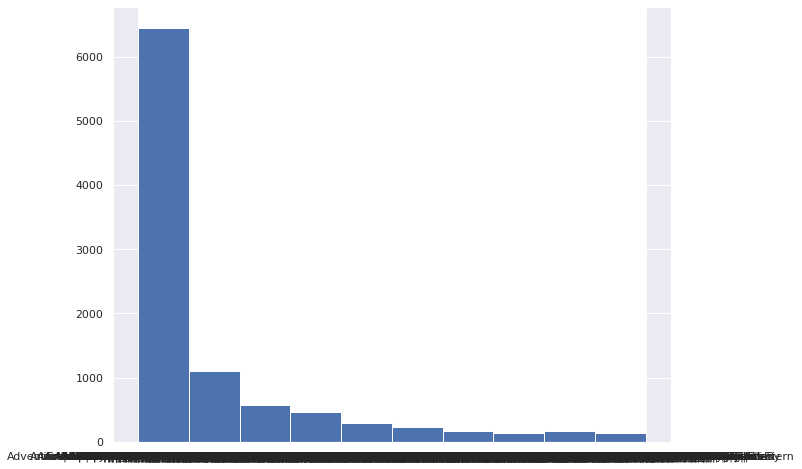

In [ ]:
movies['genres'].hist()

In [ ]:
ratings=pd.read_csv('/content/ml-latest-small/ratings.csv')

In [ ]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
joined=pd.merge(movies, ratings, 'left', on ='movieId' )

In [ ]:
joined.head(5)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


In [ ]:
movies.info

<bound method DataFrame.info of       movieId  ...                                       genres
0           1  ...  Adventure|Animation|Children|Comedy|Fantasy
1           2  ...                   Adventure|Children|Fantasy
2           3  ...                               Comedy|Romance
3           4  ...                         Comedy|Drama|Romance
4           5  ...                                       Comedy
...       ...  ...                                          ...
9737   193581  ...              Action|Animation|Comedy|Fantasy
9738   193583  ...                     Animation|Comedy|Fantasy
9739   193585  ...                                        Drama
9740   193587  ...                             Action|Animation
9741   193609  ...                                       Comedy

[9742 rows x 3 columns]>

In [ ]:
ratings.info

<bound method DataFrame.info of         userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]>

In [ ]:
joined.info

<bound method DataFrame.info of         movieId  ...     timestamp
0             1  ...  9.649827e+08
1             1  ...  8.474350e+08
2             1  ...  1.106636e+09
3             1  ...  1.510578e+09
4             1  ...  1.305696e+09
...         ...  ...           ...
100849   193581  ...  1.537109e+09
100850   193583  ...  1.537110e+09
100851   193585  ...  1.537110e+09
100852   193587  ...  1.537110e+09
100853   193609  ...  1.537158e+09

[100854 rows x 6 columns]>

In [ ]:
joined.genres = joined.genres.str.split('|') 


In [ ]:
joined.head(5)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,4.0,9.649827e+08
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5.0,4.0,8.474350e+08
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7.0,4.5,1.106636e+09
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15.0,2.5,1.510578e+09
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17.0,4.5,1.305696e+09


In [ ]:
import numpy as np
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [ ]:
joined_e = explode(joined, ['genres']) 
joined_e.head()


ValueError: ignored

In [ ]:
joined_e = explode(joined, ['genres']) 
joined_e.head()

,movieId,rating,timestamp,title,userId,genres
0,1,4.0,964982703.0,Toy Story (1995),1.0,Adventure
1,1,4.0,964982703.0,Toy Story (1995),1.0,Animation
2,1,4.0,964982703.0,Toy Story (1995),1.0,Children
3,1,4.0,964982703.0,Toy Story (1995),1.0,Comedy
4,1,4.0,964982703.0,Toy Story (1995),1.0,Fantasy


In [ ]:
joined_e.info

<bound method DataFrame.info of         movieId  rating  ...  userId     genres
0             1     4.0  ...     1.0  Adventure
1             1     4.0  ...     1.0  Animation
2             1     4.0  ...     1.0   Children
3             1     4.0  ...     1.0     Comedy
4             1     4.0  ...     1.0    Fantasy
...         ...     ...  ...     ...        ...
274513   193583     3.5  ...   184.0    Fantasy
274514   193585     3.5  ...   184.0      Drama
274515   193587     3.5  ...   184.0     Action
274516   193587     3.5  ...   184.0  Animation
274517   193609     4.0  ...   331.0     Comedy

[274518 rows x 6 columns]>

In [ ]:
joined_e.head(5)

,movieId,rating,timestamp,title,userId,genres
0,1,4.0,964982703.0,Toy Story (1995),1.0,Adventure
1,1,4.0,964982703.0,Toy Story (1995),1.0,Animation
2,1,4.0,964982703.0,Toy Story (1995),1.0,Children
3,1,4.0,964982703.0,Toy Story (1995),1.0,Comedy
4,1,4.0,964982703.0,Toy Story (1995),1.0,Fantasy


Text(50.0, 0.5, 'genres')

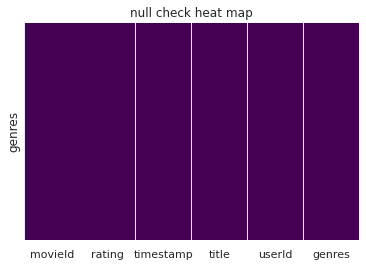

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.heatmap(joined_e.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('null check heat map')
plt.ylabel('genres')

In [ ]:
joined_e['rating'].isnull().sum()

38

In [ ]:
joined_e['timestamp'].isnull().sum()

38

In [ ]:
joined_e['title'].isnull().sum()

0

In [ ]:
joined_ed=joined_e[~joined_e['userId'].isnull()]

In [ ]:
joined_ed['timestamp'].isnull().sum()

0

In [ ]:
joined_ed.head(5)

,movieId,rating,timestamp,title,userId,genres,rating_n
0,1,4.0,964982703.0,Toy Story (1995),1.0,Adventure,0.000004
1,1,4.0,964982703.0,Toy Story (1995),1.0,Animation,0.000004
2,1,4.0,964982703.0,Toy Story (1995),1.0,Children,0.000004
3,1,4.0,964982703.0,Toy Story (1995),1.0,Comedy,0.000004
4,1,4.0,964982703.0,Toy Story (1995),1.0,Fantasy,0.000004


In [ ]:
joined_

In [ ]:
joined_e['genres'].isnull().sum()

0

In [ ]:
joined_e['title'].isnull().sum()

Text(0.5, 1.0, 'Correlation betwen columns')

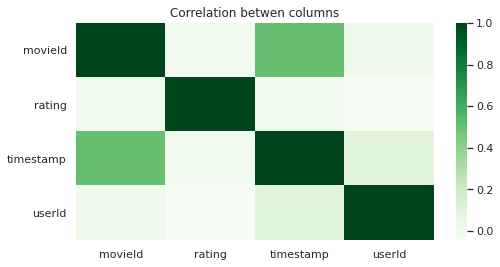

In [209]:
plt.figure(figsize=(8,4))
sns.heatmap(joined_e.corr(),cmap='Greens',annot=False)
plt.title('Correlation betwen columns')


Text(0, 0.5, 'number of ratings')

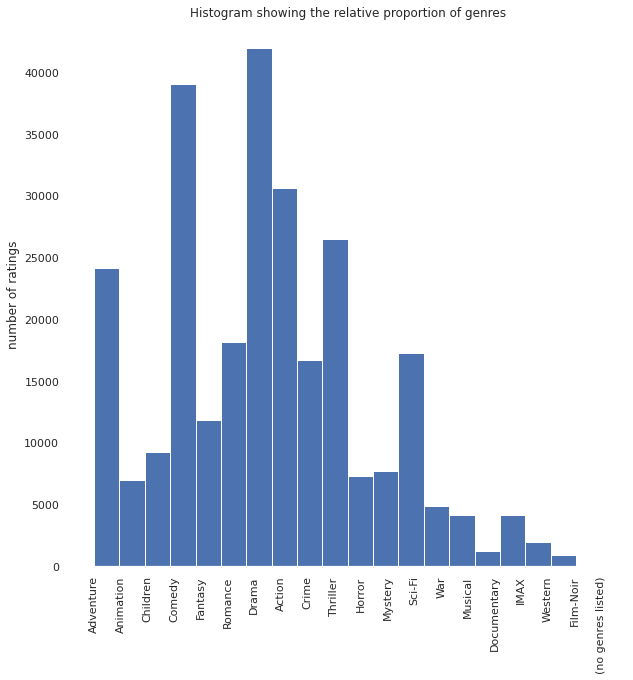

In [216]:
joined_e['genres'].hist(bins=20,figsize=(10,10))
plt.xticks(rotation=90)
plt.grid(False)
plt.title('Histogram showing the relative proportion of genres')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.ylabel('number of ratings')





In [ ]:
joined_e['genres'].hist(bins=5)
plt.xticks(rotation=90)


(array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 7 Text major ticklabel objects>)

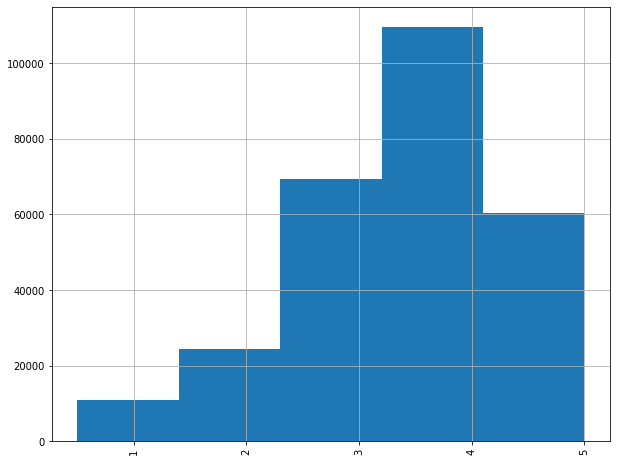

In [ ]:
joined_e['rating'].hist(bins=5)
plt.xticks(rotation=90)

In [ ]:
fig,ax=subplots()
ax.plot(joined_e['rating'],)

In [ ]:
  joined_e.plot(x="rating", y=[rating],ax=axes[count],figsize=(16,8), kind='scatter', c=df['genres'], cmap='gray')

In [ ]:
df_plot.groupby('unit number')['sensor measurement  12'].plot(legend=True,figsize=(14,8),linewidth=0.1)

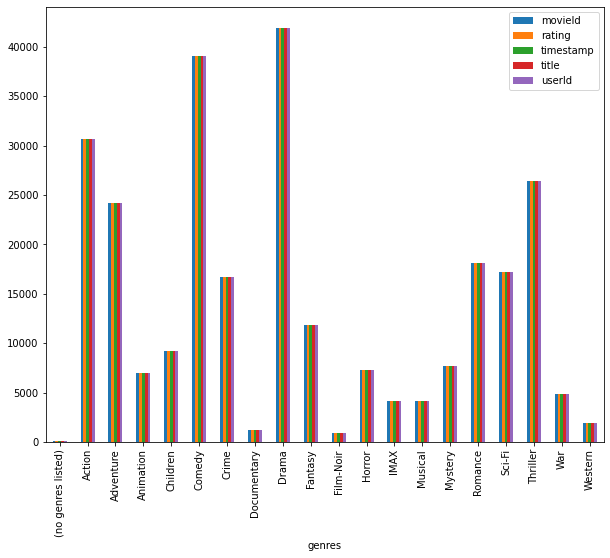

In [ ]:
joined_e.groupby(joined_e.genres).count().plot(kind="bar")


joined_e.groupby(joined_e.genres)['rating']\
    .value_counts()\
    .unstack(1)\
    .plot(kind='bar', stacked=True)


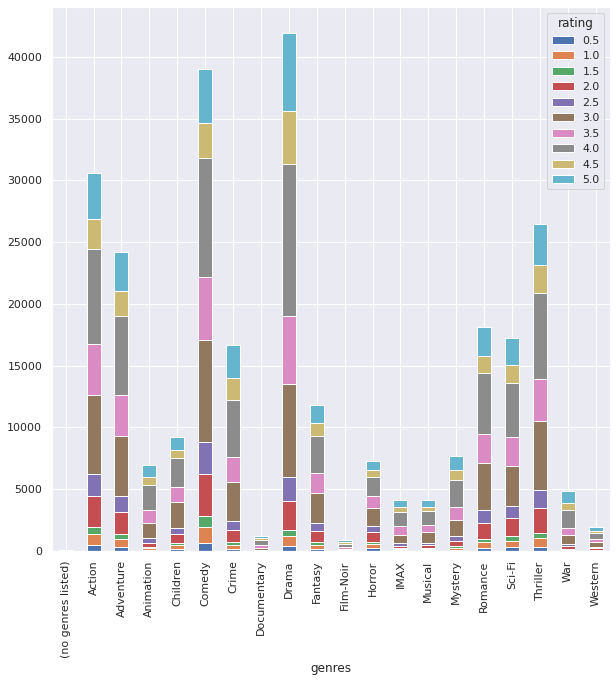

In [ ]:
joined_e.groupby(joined_e.genres)['rating']\
.value_counts()\
.unstack(1)\
.plot(kind='bar', stacked=True,figsize=(10,10))

In [ ]:
#plt.text( va = 'center', ha = 'center')
plt.text(2,0.5,'boy')

In [ ]:
#df_total = df["Studied"] + df["Slept"] + df["Other"] 
#df_rel = df[df.columns[1:]].div(df_total, 0)*100
  
for n in df_rel: 
    for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n],  
                                         df[n], df_rel[n])): 
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%',  
                 va = 'center', ha = 'center')
        plt.text()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f66e1c56f60>],
      dtype=object)

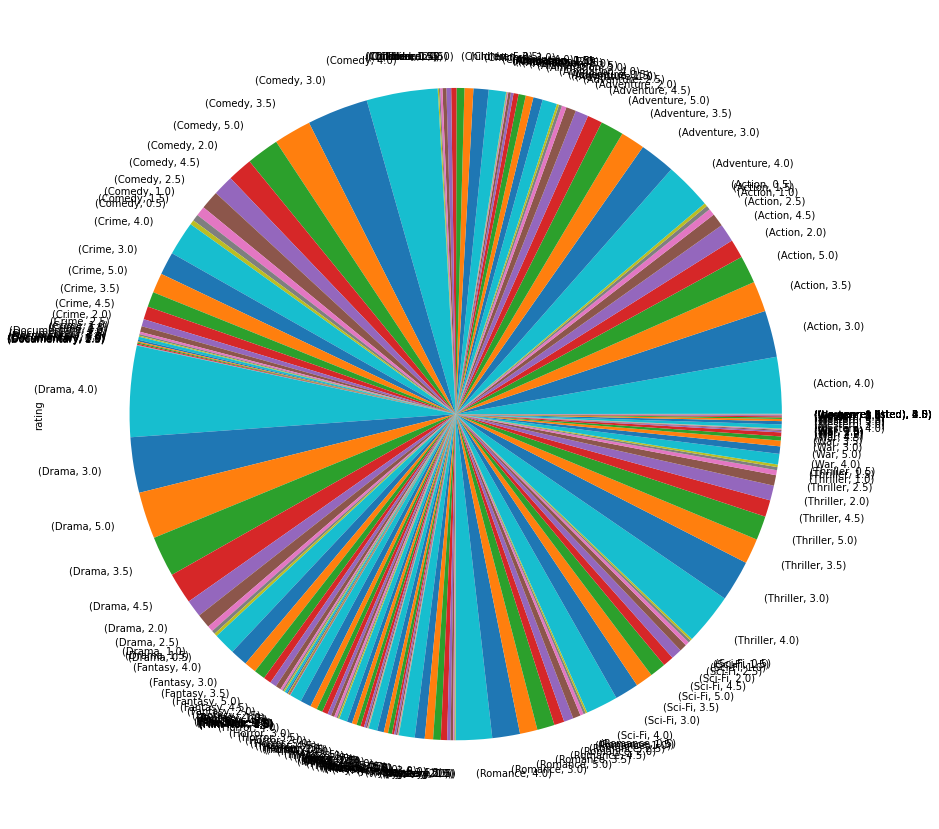

In [ ]:
joined_e.groupby(joined_e.genres)['rating']\
    .value_counts()\
    .plot(subplots=True,kind='pie',figsize=(15,15))

In [ ]:
def normalize_column(values):
  sum = np.sum(values)
  #max = np.max(values)
  norm = (values)/(sum) 
  return(pd.DataFrame(norm))

In [ ]:
data_nu=pd.DataFrame([['Twitter',5 ],['Twit',4 ],['Twi',3 ]])
print(data_nu)

         0  1
0  Twitter  5
1     Twit  4
2      Twi  3


In [ ]:
data_n=normalize_column(data_nu[1])
print(data_n)

          1
0  0.416667
1  0.333333
2  0.250000


In [ ]:
joined_e['rating_n']=normalize_column(joined_e['rating'])

In [ ]:
joined_e.head(5)

,movieId,rating,timestamp,title,userId,genres,rating_n
0,1,4.0,964982703.0,Toy Story (1995),1.0,Adventure,0.000004
1,1,4.0,964982703.0,Toy Story (1995),1.0,Animation,0.000004
2,1,4.0,964982703.0,Toy Story (1995),1.0,Children,0.000004
3,1,4.0,964982703.0,Toy Story (1995),1.0,Comedy,0.000004
4,1,4.0,964982703.0,Toy Story (1995),1.0,Fantasy,0.000004


In [ ]:
type(cross)

pandas.core.frame.DataFrame

In [ ]:
cross=pd.crosstab(joined_e['genres'],joined_e['rating'])

In [ ]:
cross

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
genres,,,,,,,,,,
(no genres listed),2,2,0,2,6,6,6,8,8,7
Action,449,904,577,2548,1777,6331,4153,7678,2468,3750
Adventure,306,627,415,1769,1352,4838,3285,6392,2027,3150
Animation,80,116,96,346,365,1279,1051,1988,682,985
Children,169,301,161,721,530,2054,1205,2358,648,1061
Comedy,632,1317,895,3405,2530,8306,5086,9659,2794,4429
Crime,152,321,204,982,772,3116,2057,4621,1769,2687
Documentary,6,16,2,33,42,163,228,415,161,153
Drama,405,795,485,2339,1922,7541,5514,12360,4217,6350


In [ ]:
cross_n=cross
for element in range(len(cross)):
  cross_n.iloc[element,:]=(cross.iloc[element,:])/np.sum(cross.iloc[element,:])

In [ ]:
np.sum(cross.iloc[0,:])

47

In [ ]:
cross.iloc[0,:]

rating
0.5   NaN
1.0   NaN
1.5   NaN
2.0   NaN
2.5   NaN
3.0   NaN
3.5   NaN
4.0   NaN
4.5   NaN
5.0   NaN
Name: (no genres listed), dtype: float64

In [ ]:
cross_n

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
genres,,,,,,,,,,
(no genres listed),0.042553,0.042553,0.000000,0.042553,0.127660,0.127660,0.127660,0.170213,0.170213,0.148936
Action,0.014656,0.029509,0.018835,0.083173,0.058006,0.206659,0.135564,0.250628,0.080561,0.122409
Adventure,0.012665,0.025951,0.017176,0.073217,0.055958,0.200240,0.135963,0.264559,0.083896,0.130375
Animation,0.011448,0.016600,0.013738,0.049513,0.052232,0.183028,0.150401,0.284488,0.097596,0.140956
Children,0.018354,0.032689,0.017485,0.078301,0.057559,0.223067,0.130864,0.256082,0.070374,0.115226
Comedy,0.016183,0.033723,0.022918,0.087189,0.064784,0.212685,0.130233,0.247331,0.071544,0.113410
Crime,0.009112,0.019243,0.012229,0.058869,0.046280,0.186799,0.123314,0.277022,0.106049,0.161081
Documentary,0.004922,0.013126,0.001641,0.027071,0.034454,0.133716,0.187039,0.340443,0.132075,0.125513
Drama,0.009659,0.018961,0.011567,0.055786,0.045840,0.179856,0.131511,0.294791,0.100577,0.151450


Text(0, 0.5, 'Percentage')

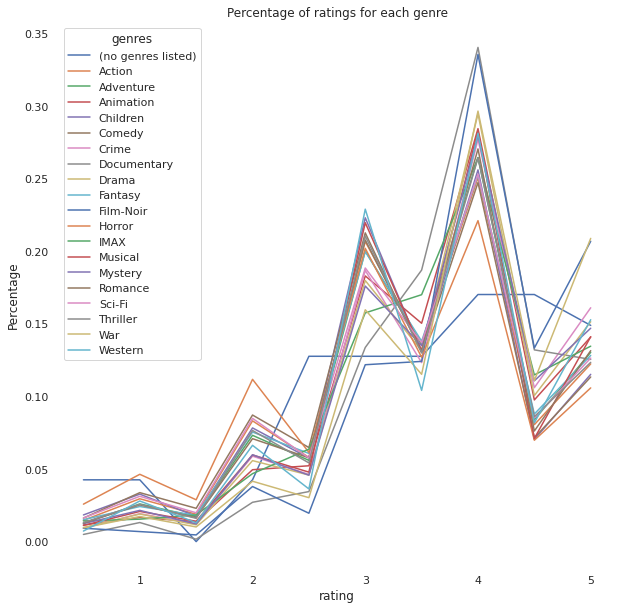

In [247]:
cross_n.transpose().plot(figsize=(10,10))
#plt.xticks(rotation=90)
plt.title ('Percentage of ratings for each genre')
plt.ylabel ('Percentage')

3.2
3.0500000000000003
2.9000000000000004
2.7500000000000004
2.6000000000000005
2.4500000000000006
2.3000000000000007
2.150000000000001
2.000000000000001
1.850000000000001
1.700000000000001
1.5500000000000012
1.4000000000000012
1.2500000000000013
1.1000000000000014
0.9500000000000014
0.8000000000000014
0.6500000000000014
0.5000000000000013
0.3500000000000013


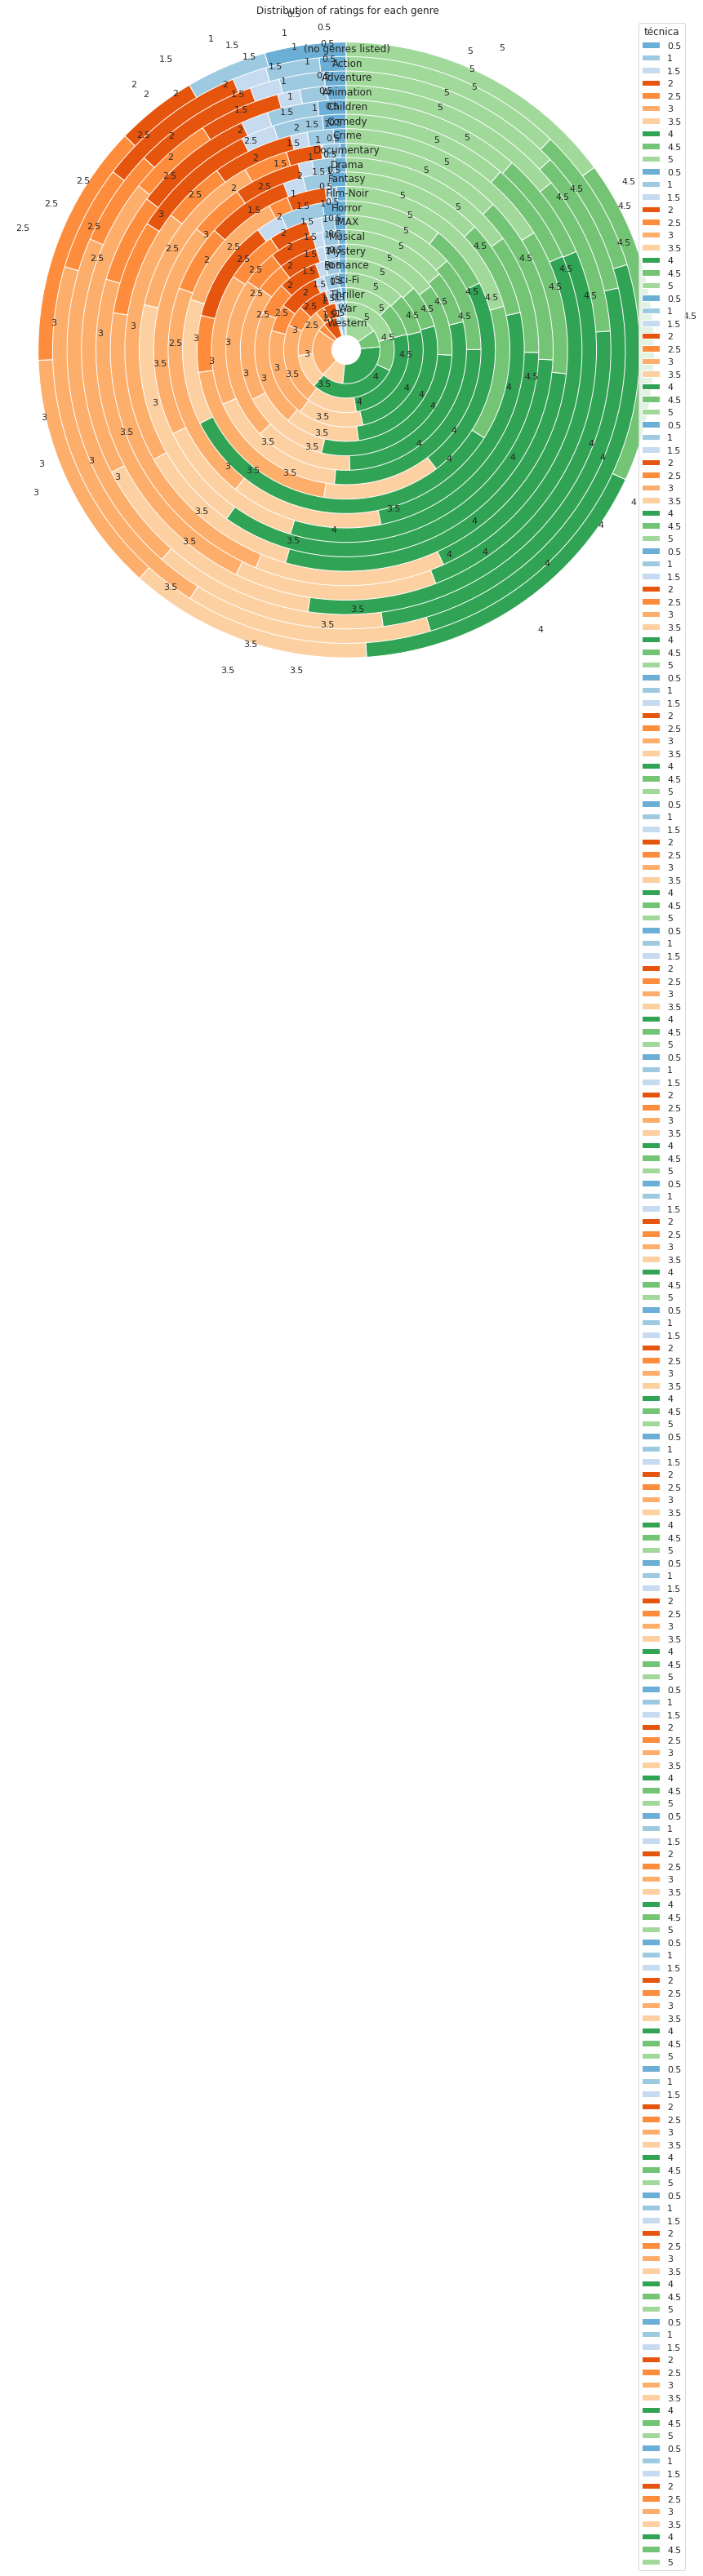

In [253]:
import pandas as pd
plt.figure(figsize=(15,15))

# create donut plots
startingRadius = 2.2+ (0.5* (len(data)-1))
for index, row in cross_n.iterrows():
    scenario = index
    percentage = row[1]
    #textLabel = scenario + ' ' + percentage
    textLabel=scenario
    print(startingRadius)
 
    cmap = plt.get_cmap("tab20c")
    inner_colors = cmap(np.array([1,2,3,4,5,6,7,8,9,10]))

    plt.text(0.01, startingRadius -0.07, textLabel, horizontalalignment='center', verticalalignment='center')
    labels = '0.5', '1', '1.5', '2','2.5','3','3.5','4','4.5','5'
    plt.pie(row, radius=startingRadius, startangle=90, labels=labels,colors=inner_colors, wedgeprops={"edgecolor": "white", 'linewidth': 1})
    plt.title ('Distribution of ratings for each genre')
    #colors=['#d5f6da', '#5cdb6f']
    startingRadius-=0.15
# equal ensures pie chart is drawn as a circle (equal aspect ratio)
plt.axis('equal')
plt.legend(title="técnica",loc =  'upper right')

# create circle and place onto pie chart
circle = plt.Circle(xy=(0, 0), radius=.15, facecolor='white')
plt.gca().add_artist(circle)
plt.savefig('donutPlot.jpg')
plt.show();

In [ ]:
joined_e['quarter']=joined_e.timestamp.quarter

AttributeError: ignored

In [ ]:
joined_e['year_of_birth'] = joined_e['timestamp'].map(lambda x: datetime.fromtimestamp(x).strftime('%Y')  )


ValueError: ignored

In [ ]:
joined_e['timestamp'][0].quarter

AttributeError: ignored

In [ ]:
from datetime import datetime

datetime.fromtimestamp(joined_e['timestamp'][0]).strftime('%Y')

'2000'